In [31]:
# Author: Abhishek Nayak
# from re import S
import sys
sys.path.append('DubinsLineSegToLineSeg/')

from graphutils import is_path_exists, is_route_continuous, is_feasible_path, is_angle_matching, get_shortest_path
from graphutils import ConstructGates, ConnectGates_Dubins, GraphUpdate_BreakGate, UpdatePath_Dubins, GraphUpdate_BreakAngle
from graphutils import ConnectGates_Euclidean, UpdatePath_Euclidean, EuclideanToDubinsGraph
from graphutils import PlotGstar
from graphutils import Graph_Gstar
from DubinsLineSegToLineSeg import DubinsL2L
from map_utils import Map
from copy import deepcopy
import pickle as pkl
import dubins as du
import time
import networkx as nx
import numpy as np
import csv
import os
import yaml
import logging

from networkx.algorithms.shortest_paths.generic import shortest_path
# from networkx.classes.graph import Graph
sys.path.append('DubinsLineSegToLineSeg/')

step_size = 0.1
bound_resolution = 1


def GstarPaths(Map, G, timeLimit, imgPath, heading_restricted, headingAngles):

    '''
    This function computes the Euclidean and Dubins lower and upper bounds of the shortest path
    between the start and goal points in the input Map. If the shortest path is feasible, the
    function terminates. Otherwise, it constructs and connects gates to update the graph and
    continues the computation until the shortest path is feasible or the time limit is reached.

    Args:
    - Map: An object of the Map class, containing the obstacles and start and goal points
    - G: An object of the Graph class, containing the nodes and edges of the graph
    - timeLimit: The maximum computation time allowed for finding the shortest path
    - imgPath: The path where the images of the computed paths will be saved
    - heading_restricted: A boolean indicating whether the heading angles at the start and goal
                          points are restricted or not
    - headingAngles: A dictionary containing the restricted heading angles at the start and goal
                     points (if any)

    Returns:
        A tuple containing the lower bounds of the G* algorithm, the map object, and the GStarGraph object.
    '''

    # Compute the Euclidean upper bound of the shortest path
    eucBoundStartTime = time.monotonic()
    short_path_list, G.eucLB_free = get_shortest_path('s', 'e', G)

    if heading_restricted:
        outAngle = headingAngles['startAngle']*np.pi/180
        inAngle = headingAngles['goalAngle']*np.pi/180
    else:
        outAngle, inAngle = 0, 0

    # Compute the Dubins upper bound of the shortest path
    delta = 0.001
    dubLB_free = DubinsL2L.Line2LineDubins(G.LineStart, (outAngle-delta, outAngle+delta), G.LineEnd, (inAngle-delta, inAngle+delta), G.rho)
    G.dubLB_free, minPath = dubLB_free.MinDub_L2L()

    # Print the Euclidean and Dubins upper bounds
    print("Euclidean Upper Bound (No Obstacles): ", G.eucLB_free)
    print("Dubins Upper Bound (No Obstacles): ", G.dubLB_free)

    ''' Step 1: Construct Euclidean Lower bounds '''
    if not is_feasible_path(short_path_list, G, Map.ObstacleList):
        improve_bounds = True
    else:
        improve_bounds = False

    print('### Solving Euclidean Lower Bound ###')
    loop = 0
    G.eucLB_time, eucBoundStartTime = 0, time.monotonic()
    improve_bounds = True
    
    while improve_bounds and (G.eucLB_time < 0.001*timeLimit):
        path_exists = is_path_exists('s', 'e', G)
        path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
        path_continuous = is_route_continuous(short_path_list, G)

        if path_exists and path_continuous and path_feasible:
            improve_bounds = False
        else:
            if not path_feasible:
                G = ConstructGates(G, Map, short_path_list,graphType='Euclidean')
                G = ConnectGates_Euclidean(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)

            if not path_continuous:
                G = GraphUpdate_BreakGate(G, short_path_list)
                G = UpdatePath_Euclidean(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
        
        print('Path: ', short_path_list)
        G.eucLB_time = time.monotonic()-eucBoundStartTime
        loop += 1
        plotTitle = "Euclidean Lower Bound (length = " + str(round(short_path_length, 3)) + ")"
        PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_euc', action='display')

    G.eucLowerPath, G.eucLowerBound = short_path_list, short_path_length
    G.eucGraph = deepcopy(G.graph)

    print(nx.info(G.graph))
    print('Euclidean Lower Bound: ', G.eucLowerBound)
    print("Time (Euclindean Lower Bound): ", G.eucLB_time)
    plotTitle = "Euclidean Lower Bound (length = " + str(round(G.eucLowerBound, 3)) + ")"
    PlotGstar(G.eucLowerPath, G, Map, plotTitle, save_path=imgPath+'/eucLB', action='display')

    """ Step 2:  Compute Dubins Lower Bound """
    print('### Solving Dubins Lower Bound ###')
    times, Gstar_path_lengths = [], []
    dubBoundStartTime = time.monotonic()
    improve_bounds = True

    G = EuclideanToDubinsGraph(G, heading_restricted, startAngle=outAngle, goalAngle=inAngle)
    G = ConnectGates_Dubins(G)

    short_path_list, short_path_length = get_shortest_path('s', 'e', G)
    times.append(time.monotonic() - dubBoundStartTime)
    Gstar_path_lengths.append(short_path_length)
    loop += 1
    
    plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
    PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath +'/step_'+str(loop)+'_dub', action='display')

    print(short_path_list)
    print('G* lower bound distance: ', short_path_length)
    # PlotGstar(short_path_list, G.graph, self.Map, loop, title)
    G.dubLB_time = time.monotonic()-dubBoundStartTime

    '''### G* lower bounds ###'''
    '''### REPLACE EUCLIDEAN PATHS WITH DubLineToLine ###'''
    while improve_bounds and (G.dubLB_time < timeLimit):
        path_exists = is_path_exists('s', 'e', G)
        path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
        path_continuous = is_route_continuous(short_path_list, G)
        angle_matching = is_angle_matching(short_path_list, G)

        if path_exists and path_continuous and path_feasible and angle_matching:
            improve_bounds = False
            # break
        else:
            if not path_feasible:
                logging.info('loop {}', loop)
                logging.info('Constructing New Gates...')
                G = ConstructGates(G, Map, short_path_list, graphType='Dubins')
                G = ConnectGates_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='save')

            if not path_continuous:
                logging.info('Breaking Gates...')
                G = GraphUpdate_BreakGate(G, short_path_list)
                # G = ConnectGates_Dubins(G)
                G = UpdatePath_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

            if not angle_matching:
                logging.info('Optimizing Angle...')
                G = GraphUpdate_BreakAngle(G, short_path_list)
                ## G = ConnectGates_Dubins(G)
                G = UpdatePath_Dubins(G)
                short_path_list, short_path_length = get_shortest_path('s', 'e', G)
                # PlotGstar(short_path_list, G, Map, title, save_path='./images', action='display')

            G.dubLB_time = time.monotonic()-dubBoundStartTime
            times.append(G.dubLB_time)
            Gstar_path_lengths.append(short_path_length)
            loop += 1
            plotTitle = "G* (length = " + str(round(short_path_length, 3)) + ")"
            PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_dub', action='display')
            
    
    # short_path_list, short_path_length = get_shortest_path('s', 'e', G)
    G.dubLowerPath, G.dubLowerBound = short_path_list, short_path_length
    print("G* Bound Time: ", G.dubLB_time)
    print("G* Path: ", G.dubLowerPath)
    print('G* lower bound distance: ', G.dubLowerBound)
    plotTitle = "G* (length = " + str(round(G.dubLowerBound, 3)) + ")"

    return G.dubLowerPath, Map, G


if __name__ == "__main__":

    timeLimit = 1800
    radius_list = [1, 2, 3]
    initial_Sectors = 3
    start_conf = (0, 2, 0)
    end_conf = (16, 4.5, 0)
    heading_restricted = True

    instance_paths = ['./instances/map1']

    for path in instance_paths:

        with open(path+'/tolerances.yaml') as toleances_yaml:
            tolerances = yaml.load(toleances_yaml, Loader=yaml.FullLoader)

        with open(path+'/heading.yaml') as heading_yaml:
            headingAngles = yaml.load(heading_yaml, Loader=yaml.FullLoader)

        result_fields = ['name', 'path', 'Obstacles', 'turning_radius', 'continuity_tolerance', 'angle_tolerance', 'node_count',
                         'edge_count', 'eucLB_NoObstacles', 'dubLB_NoObstacles', 'eucLB', 'eucLB_time', 'dubLB', 'dubLB_time',  'dubUB', 'dubUB_time']
        result_filename = path+'/results_' + \
            time.strftime("%Y%m%d-%H%M%S")+'.csv'

        # writing to csv file
        with open(result_filename, 'w') as csvfile:
            # creating a csv writer object
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(result_fields)

            # writing the data rows
            instance_results = []
            for (instance_path, dirs, files) in os.walk(path):
                for f in files:
                    if f.endswith(".pkl"):
                        obstacle_count = instance_path.split("/")[-2]
                        obstacle_count = obstacle_count.split('_')[1]

                        # M = Map(start_conf, end_conf, (15,8), obstacle_count, shape=5)
                        filepath = instance_path+'/' + f
                        if f.split('_')[0] == 'Map':
                            m = open(filepath, 'rb')
                            Map = pkl.load(m)

                            for rho in radius_list:
                                print(
                                    "\n--------------------------------------------------------------------------")
                                print("Instance: ", instance_path +
                                      '/'+f, " Radius: ", rho)
                                print("Tolerances: ", tolerances)
                                G = Graph_Gstar(
                                    start_conf, end_conf, rho, initial_Sectors, tolerances)
                                imgPath = instance_path+'/img/r_'+str(rho)
                                if not os.path.exists(imgPath):
                                    os.makedirs(imgPath)

                                try:

                                    start_time = time.monotonic()
                                    # if not os.path.exists(instance_path+'/graphs/G_r'+str(rho)+'.pkl'):
                                    try:
                                        dubLB_path, Map, G = GstarPaths(
                                            Map, G, timeLimit, imgPath, heading_restricted, headingAngles)
                                        PlotGstar(dubLB_path, G, Map, 'G* Lower Bound Path',
                                                    save_path=instance_path+'/dub_LB_r'+str(rho), action='save')
                                        print('test')

                                        total_time = time.monotonic() - start_time
                                        print('Time of execution: ',
                                                total_time)
                                    except:
                                        None

                                    if not os.path.exists(instance_path+'/graphs'):
                                        os.mkdir(instance_path+'/graphs')
                                    G_filename = instance_path + \
                                        '/graphs/G_r'+str(rho)+'.pkl'
                                    G_file = open(G_filename, 'wb')
                                    pkl.dump(G, G_file)
                                    G_file.close()

                                    instance_data = [
                                        f, 
                                        filepath, 
                                        obstacle_count, 
                                        rho, 
                                        tolerances['continuity'], 
                                        tolerances['angular'], 
                                        G.graph.number_of_nodes(), 
                                        G.graph.size(), 
                                        G.eucLB_free, 
                                        G.dubLB_free, 
                                        G.eucLowerBound, 
                                        G.eucLB_time, 
                                        G.dubLowerBound, 
                                        G.dubLB_time, 
                                        G.dubUpperBound, 
                                        G.dubUB_time
                                        ]
                                    csvwriter.writerow(instance_data)

                                except:
                                    None


--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  1
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  5.0
Dubins Upper Bound (No Obstacles):  6.820510415464687
### Solving Euclidean Lower Bound ###
Path:  [0, 1]

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  2
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}
Euclidean Upper Bound (No Obstacles):  5.0
Dubins Upper Bound (No Obstacles):  17.562370614359175
### Solving Euclidean Lower Bound ###
Path:  [0, 1]

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  3
Tolerances:  {'continuity': 0.1, 'angular': 15, 'poly

In [4]:
Map.StartConf

(0, 4.5, 0)

In [5]:
Map.EndConf

(16, 4.5, 3.141592653589793)

In [6]:
tolerances

{'continuity': 0.1,
 'angular': 15,
 'polygon_intersection': 0.7,
 'circle_intersection_ratio': 0.5}

In [7]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from types import SimpleNamespace
from DubinsLineSegToLineSeg import utils
from DubinsLineSegToLineSeg import dubutils as du

In [8]:
tole

NameError: name 'tole' is not defined

In [ ]:
def GstarPaths(Map, G, timeLimit, imgPath, heading_restricted, headingAngles):
    
    eucBoundStartTime = time.monotonic()

In [9]:
from graphutils import get_shortest_path, node_id_list
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString, mapping

In [10]:
G = Graph_Gstar(start_conf, end_conf, rho, initial_Sectors, tolerances)

In [11]:
short_path_list, G.eucLB_free = get_shortest_path('s', 'e', G)

In [10]:
if heading_restricted:
    outAngle = headingAngles['startAngle']*np.pi/180
    inAngle = headingAngles['goalAngle']*np.pi/180
else:
    outAngle, inAngle = 0, 0


In [11]:
ou

NameError: name 'ou' is not defined

In [12]:
delta = 0.001
dubLB_free = DubinsL2L.Line2LineDubins(G.LineStart, (outAngle-delta, outAngle+delta), G.LineEnd, (inAngle-delta, inAngle+delta), G.rho)
# G.dubLB_free, minPath = dubLB_free.MinDub_L2L()
minLength, minPath = dubLB_free.MinDub_L2L()

In [13]:
lineSeg1 = G.LineStart
lineSeg2 = G.LineEnd
int1 = (outAngle-delta, outAngle+delta)
int2 = (inAngle-delta, inAngle+delta)
rho = G.rho

minLength=21.264214093935287
minPathType= RSL
minConfStart=  (0, 4.49)   1.5697963267948967
minConfGoal=  (16, 4.51)   1.5697963267948967
Segment lengths=  (6.632084047035267, 8.000045999864751, 6.632084047035267)
comp_time=3.962500022680615e-05


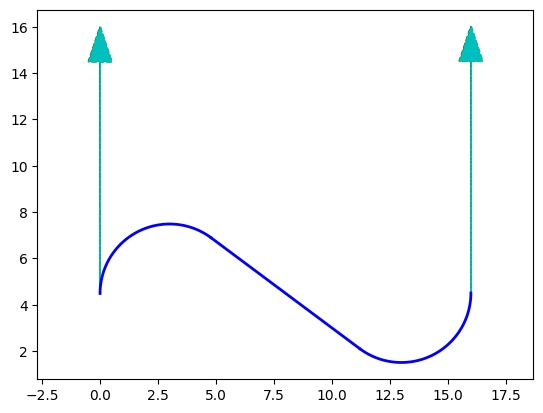

In [14]:
plotFlag  = True
## computing shortest line to line dubins path using analytical results
tic = timer()
# L2LDub = DubinsL2L.Line2LineDubins(lineSeg1, int1, lineSeg2, int2, rho) 
# minLength, minPath = L2LDub.MinDub_L2L()   #This returns the length of the minimum path, minimum path, and all the candidate paths
comp_time = timer()-tic
print(f"{minLength=}")
print("minPathType=", minPath.pathType)
print("minConfStart= ", minPath.iniPos, " ", minPath.iniHead)
print("minConfGoal= ", minPath.finalPos, " ", minPath.finalHead)
print("Segment lengths= ", minPath.segLengths)
print(f"{comp_time=}")

if plotFlag:
    plt.figure()
    linesegfmt = SimpleNamespace(color='m', linewidth=1.5, linestyle='-', marker='x',endPoints=True)        
    pathfmt = SimpleNamespace(color='b', linewidth=2, linestyle='-', marker='x', endPoints=False)    
    arrfmt = SimpleNamespace(color='g', linewidth=1, linestyle='--', marker='x', arrLen=10)       
    utils.PlotLineSeg(lineSeg1[0], lineSeg1[1], linesegfmt)
    utils.PlotLineSeg(lineSeg2[0], lineSeg2[1], linesegfmt)
    if minLength:   
        arrfmt = SimpleNamespace(color='g', linewidth=1, linestyle='--', marker='x', arrLen=10)                   
        utils.PlotInterval(minPath.iniPos, int1, arrfmt)
        utils.PlotInterval(minPath.finalPos, int2, arrfmt)
        du.PlotDubPathSegments((minPath.iniPos[0], minPath.iniPos[1], minPath.iniHead), minPath.pathType, minPath.segLengths, rho, pathfmt)     
        arrfmt = SimpleNamespace(color='c', linewidth=1, linestyle='--', marker='x', arrLen=10)           
        utils.PlotArrow(minPath.finalPos, minPath.finalHead, 10, arrfmt) 
        utils.PlotArrow(minPath.iniPos, minPath.iniHead, 10, arrfmt)            
 
    plt.axis('equal')
    plt.show()


In [15]:
G.dubLB_free = minLength

In [16]:
print("Euclidean Upper Bound (No Obstacles): ", G.eucLB_free)
print("Dubins Upper Bound (No Obstacles): ", G.dubLB_free)

Euclidean Upper Bound (No Obstacles):  16.0
Dubins Upper Bound (No Obstacles):  21.264214093935287


In [17]:
def is_feasible_path(Path, G, obstacleList):
    feasible = True
    for i in range(len(Path)-1):
        u = Path[i]
        v = Path[i+1]
        Edge = G.graph.get_edge_data(u, v)

        for obstacle in obstacleList:
            feasible = is_feasible_connection(Edge, obstacle, G.tolerances)
            if not feasible:
                return False

    return feasible

In [18]:
def is_feasible_connection(Edge, obstacle, Tolerances):
    feasible = True
    ''' if the path is a single line segment '''
    if mapping(Edge['geom'])['type'] == 'LineString':
        if Edge['geom'].within(obstacle) or Edge['geom'].overlaps(obstacle):
            return False
        if Edge['geom'].crosses(obstacle):
            if mapping(obstacle)['type'] == 'Polygon':
                s = Edge['geom'].intersection(obstacle).length
                if s > Tolerances['polygon_intersection']:
                    return False
            else:
                s = Edge['geom'].intersection(obstacle).length
                d = math.sqrt(4*obstacle.area/math.pi)
                if (s/d) > Tolerances['circle_intersection_ratio']:
                    return False
    elif mapping(Edge['geom'])['type'] == 'MultiLineString':
        for segment in list(Edge['geom']):
            if segment.within(obstacle) or segment.overlaps(obstacle):
                return False
            if segment.crosses(obstacle):
                if mapping(obstacle)['type'] == 'Polygon':
                    s = segment.intersection(obstacle).length
                    if s > Tolerances['polygon_intersection']:
                        return False
                else:
                    s = segment.intersection(obstacle).length
                    d = math.sqrt(4*obstacle.area/math.pi)
                    if (s/d) > (s/d) > Tolerances['circle_intersection_ratio']:
                        return False
    return feasible

In [19]:
is_feasible_path(short_path_list, G, Map.ObstacleList)

False

In [20]:
short_path_list

[0, 1]

In [21]:
if not is_feasible_path(short_path_list, G, Map.ObstacleList):
    improve_bounds = True
else:
    improve_bounds = False


In [22]:
improve_bounds

True

In [23]:
def is_path_exists(StartId, EndId, G):
    start_id_list, end_id_list = node_id_list(
        StartId, G), node_id_list(EndId, G)
    for s in start_id_list:
        for e in end_id_list:
            if not nx.has_path(G.graph, source=s, target=e):
                return False
    return True

In [24]:
path_exists = is_path_exists('s', 'e', G)
path_exists

True

In [25]:
path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
path_feasible

False

In [26]:
path_continuous = is_route_continuous(short_path_list, G)
path_continuous

True

In [27]:
def ConstructGates(G, Map, Path, graphType='euclidean'):
    ''' 1. Draw gates for obstacles intesecting the path '''
    for i in range(len(Path)-1):
        u, v = Path[i], Path[i+1]
        Edge = G.graph.get_edge_data(u, v)
        # if is_feasible_connection(Edge, ObstacleMap) == False:
        #
        for obstacle in Map.ObstacleList:
            if mapping(Edge['geom'])['type'] == 'LineString':
                # if Edge['geom'].crosses(obstacle):
                if not is_feasible_connection(Edge, obstacle, G.tolerances):
                    # nx.G.graph.remove_edge()
                    G = add_gate(G, Edge['geom'], obstacle, Map, graphType)

            elif mapping(Edge['geom'])['type'] == 'MultiLineString':
                for segment in list(Edge['geom']):
                    # if segment.crosses(obstacle):
                    if not is_feasible_connection(segment, obstacle, G.tolerances):
                        G = add_gate(G, segment, obstacle, Map, graphType)
    return G

In [28]:
def add_gate(G, Edge, Obstacle, Map, Type):
    ''' List of points intersecting the obstacle'''
    points = list(Edge.intersection(Obstacle).coords)
    ''' Draw gates at midway of points'''
    avg_X, avg_Y = 0, 0
    
    for point in points:
        avg_X += point[0]
        avg_Y += point[1]
    
    avg_X /= len(points)
    avg_Y /= len(points)

    gate_geom = LineString([(avg_X, Map.map_maxy), (avg_X, Map.map_miny)])

    for obs in Map.ObstacleList:
        gate_geom = gate_geom - obs

    # ExistingGateList = []
    # try:
    #     ExistingGateList = [G.graph.nodes[n]['geom'] for n in list(G.graph.nodes)]
    # except AttributeError:
    #     print("Error adding new gates")

    if Type == 'Euclidean':
        if mapping(gate_geom)['type'] == 'LineString':
            # if gate_geom not in ExistingGateList:
            if gate_geom not in G.gateGeomList:
                G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                 geom=gate_geom, sector=None, x_dist=avg_X)
                G.gateGeomList.append(gate_geom)
                G.GateCounter += 1
        elif mapping(gate_geom)['type'] == 'MultiLineString':
            for gate_segment_geom in list(gate_geom):
                # if gate_segment_geom not in ExistingGateList:
                if gate_segment_geom not in G.gateGeomList:
                    G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                     geom=gate_segment_geom, sector=None, x_dist=avg_X)
                    G.gateGeomList.append(gate_segment_geom)
                    G.GateCounter += 1

    elif Type == 'Dubins':
        sector_list = [(2*np.pi*i/G.Sectors, 2*np.pi*(i+1)/G.Sectors)
                       for i in range(G.Sectors)]
        if mapping(gate_geom)['type'] == 'LineString':
            # if gate_geom not in ExistingGateList:
            if gate_geom not in G.gateGeomList:
                for sector in sector_list:
                    G.graph.add_node(G.GateCounter, id=G.GateCounter,
                                     geom=gate_geom, sector=sector, x_dist=avg_X)
                    G.gateGeomList.append(gate_geom)
                    G.GateCounter += 1
        elif mapping(gate_geom)['type'] == 'MultiLineString':
            for gate_segment_geom in list(gate_geom):
                # if gate_segment_geom not in ExistingGateList:
                if gate_segment_geom not in G.gateGeomList:
                    for sector in sector_list:
                        G.graph.add_node(
                            G.GateCounter, id=G.GateCounter, geom=gate_segment_geom, sector=sector, x_dist=avg_X)
                        G.gateGeomList.append(gate_segment_geom)
                        G.GateCounter += 1

    else:
        print('TypeError: Check selected path type')
    return G

In [29]:
def ConnectGates_Euclidean(G):
    """
    Function to connect Euclidean edges between gates.

    Attributes
    ----------
    Graph : nx.graph()
        A graph containing Gates as nodes.

    Output
    -------
    Graph : nx.graph()
        A graph containing Gates connected using Euclidean paths.

    """

    G.graph.clear_edges()
    smallest_gate_x_dist, largest_gate_x_dist = np.inf, 0
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['x_dist'] < smallest_gate_x_dist:
            smallest_gate_x_dist = G.graph.nodes[n]['x_dist']
        if G.graph.nodes[n]['x_dist'] > largest_gate_x_dist:
            largest_gate_x_dist = G.graph.nodes[n]['x_dist']

    ''' 4/1. Start path'''
    nearest_gates, nearest_gate_dist = [], np.inf
    for n in list(G.graph.nodes):
        if G.graph.nodes[n]['x_dist'] == smallest_gate_x_dist:
            nearest_gate_dist = G.graph.nodes[n]['x_dist']
            nearest_gates.append(n)

    prev_x_dist = nearest_gate_dist
    prev_gates = nearest_gates

    ''' 4/2. Gate connections '''

    while prev_x_dist < largest_gate_x_dist:
        nearest_gates, nearest_gate_dist = [], np.inf
        for n in list(G.graph.nodes):
            if G.graph.nodes[n]['x_dist'] < nearest_gate_dist and G.graph.nodes[n]['x_dist'] > prev_x_dist:
                nearest_gate_dist = G.graph.nodes[n]['x_dist']
                nearest_gates = [n]
            elif G.graph.nodes[n]['x_dist'] == nearest_gate_dist:
                nearest_gates.append(n)

        for a in prev_gates:
            for b in nearest_gates:
                near_points = nearest_points(
                    G.graph.nodes[a]['geom'], G.graph.nodes[b]['geom'])
                temp_path = LineString(near_points)
                minConfStart = [near_points[0].x,
                                near_points[0].y, find_slope(temp_path)]
                minConfGoal = [near_points[1].x,
                               near_points[1].y, find_slope(temp_path)]
                G.graph.add_edge(a, b, weight=temp_path.length, geom=temp_path, pathConf=[
                                 minConfStart, minConfGoal], parent_gates=[a, b])
        prev_x_dist = nearest_gate_dist
        prev_gates = nearest_gates

    return G


In [30]:
print('### Solving Euclidean Lower Bound ###')
loop = 0
G.eucLB_time, eucBoundStartTime = 0, time.monotonic()
improve_bounds = True

while improve_bounds and (G.eucLB_time < 0.001*timeLimit):
    path_exists = is_path_exists('s', 'e', G)
    path_feasible = is_feasible_path(short_path_list, G, Map.ObstacleList)
    path_continuous = is_route_continuous(short_path_list, G)

    if path_exists and path_continuous and path_feasible:
        improve_bounds = False
    else:
        if not path_feasible:
            G = ConstructGates(G, Map, short_path_list,graphType='Euclidean')
            G = ConnectGates_Euclidean(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)

        if not path_continuous:
            G = GraphUpdate_BreakGate(G, short_path_list)
            G = UpdatePath_Euclidean(G)
            short_path_list, short_path_length = get_shortest_path('s', 'e', G)

    print('Path: ', short_path_list)
    G.eucLB_time = time.monotonic()-eucBoundStartTime
    loop += 1
    plotTitle = "Euclidean Lower Bound (length = " + str(round(short_path_length, 3)) + ")"
    PlotGstar(short_path_list, G, Map, plotTitle, save_path=imgPath+'/step_'+str(loop)+'_euc', action='display')

G.eucLowerPath, G.eucLowerBound = short_path_list, short_path_length
G.eucGraph = deepcopy(G.graph)

print(nx.info(G.graph))
print('Euclidean Lower Bound: ', G.eucLowerBound)
print("Time (Euclindean Lower Bound): ", G.eucLB_time)
plotTitle = "Euclidean Lower Bound (length = " + str(round(G.eucLowerBound, 3)) + ")"
PlotGstar(G.eucLowerPath, G, Map, plotTitle, save_path=imgPath+'/eucLB', action='display')

### Solving Euclidean Lower Bound ###


TypeError: 'MultiLineString' object is not iterable

In [31]:
G = ConstructGates(G, Map, short_path_list,graphType='Euclidean')

TypeError: 'MultiLineString' object is not iterable

In [32]:
G.graph.

SyntaxError: invalid syntax (3761764947.py, line 1)

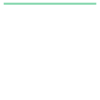

In [33]:
Edge = G.graph.get_edge_data(0,1)
Edge = Edge['geom']
Edge

In [34]:
points = Edge.intersection(Map.ObstacleList[0])

In [35]:
g = list(points.coords)
g

[(7.717878119327566, 4.5), (8.704226588619758, 4.5)]

In [36]:
avg_x = 0
for point in g:
    avg_x += point[0]
    
avg_x = avg_x/len(g)
avg_x

8.211052353973662

In [37]:
from shapely.geometry import MultiPoint

In [38]:
# Example MultiPoint boundary of an obstacle
obstacle_boundary = MultiPoint([(0, 0), (1, 1), (2, 0), (0, 2)])

# Example line to check for intersection
line = LineString([(0, 1), (2, 1)])

# Find intersection points
intersection_points = obstacle_boundary.intersection(line)

# Iterate over the intersection points
for point in intersection_points:
    if isinstance(point, Point):
        print("Intersection point:", point.x, point.y)


TypeError: 'Point' object is not iterable

In [4]:
# from re import S
import sys
sys.path.append('DubinsLineSegToLineSeg/')

from graphutils import is_path_exists, is_route_continuous, is_feasible_path, is_angle_matching, get_shortest_path
from graphutils import ConstructGates, ConnectGates_Dubins, GraphUpdate_BreakGate, UpdatePath_Dubins, GraphUpdate_BreakAngle
from graphutils import ConnectGates_Euclidean, UpdatePath_Euclidean, EuclideanToDubinsGraph
from graphutils import PlotGstar
from graphutils import Graph_Gstar
from DubinsLineSegToLineSeg import DubinsL2L
from map_utils import Map
from copy import deepcopy
import pickle as pkl
import dubins as du
import time
import networkx as nx
import numpy as np
import csv
import os
import yaml
import logging

from networkx.algorithms.shortest_paths.generic import shortest_path
# from networkx.classes.graph import Graph
sys.path.append('DubinsLineSegToLineSeg/')

step_size = 0.1
bound_resolution = 1

In [25]:
if __name__ == "__main__":

    timeLimit = 1800
    radius_list = [1, 2, 3]
    initial_Sectors = 3
    start_conf = (0, 4.5, 0)
    end_conf = (16, 4.5, 0)
    heading_restricted = True

    instance_paths = ['./instances/map1']

    for path in instance_paths:

        print(f"{path = }")
        
        with open(path+'/tolerances.yaml') as toleances_yaml:
            tolerances = yaml.load(toleances_yaml, Loader=yaml.FullLoader)
#             print(f"{tolerances = }")

        with open(path+'/heading.yaml') as heading_yaml:
            headingAngles = yaml.load(heading_yaml, Loader=yaml.FullLoader)
#             print(f"{headingAngles = }")

        result_fields = ['name', 'path', 'Obstacles', 'turning_radius', 'continuity_tolerance', 'angle_tolerance', 'node_count',
                         'edge_count', 'eucLB_NoObstacles', 'dubLB_NoObstacles', 'eucLB', 'eucLB_time', 'dubLB', 'dubLB_time',  'dubUB', 'dubUB_time']
        
        result_filename = path+'/results_' + time.strftime("%Y%m%d-%H%M%S")+'.csv'

        # writing to csv file
        with open(result_filename, 'w') as csvfile:
            # creating a csv writer object
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(result_fields)

            # writing the data rows
            instance_results = []
            for (instance_path, dirs, files) in os.walk(path):
#                 print(f"{instance_path = }")
#                 print(f"{dirs = }")
#                 print(f"{files = }")
                
                for f in files:
#                     print(f'{f = }')
                    if f.endswith(".pkl"):
#                         print(f'f that ends with .pkl : {f = }')
                        obstacle_count = instance_path.split("/")[-2]
#                         print(f"{obstacle_count = }")
                        obstacle_count = obstacle_count.split('_')[1]
#                         print(f"{obstacle_count = }")

#                         # M = Map(start_conf, end_conf, (15,8), obstacle_count, shape=5)
                        filepath = instance_path+'/' + f
                        if f.split('_')[0] == 'Map':
                            print(f'{f = }')
                            m = open(filepath, 'rb')
                            Map = pkl.load(m)

                            for rho in radius_list:
                                print( "\n--------------------------------------------------------------------------")
                                
                                print("Instance: ", instance_path +'/'+f, " Radius: ", rho)
                                
                                print("Tolerances: ", tolerances)
                                
                                G = Graph_Gstar(start_conf, end_conf, rho, initial_Sectors, tolerances)
                                
                                imgPath = instance_path+'/img/r_'+str(rho)
                                
                                if not os.path.exists(imgPath):
                                    os.makedirs(imgPath)

                                try:

                                    start_time = time.monotonic()
                                    # if not os.path.exists(instance_path+'/graphs/G_r'+str(rho)+'.pkl'):
                                    try:
                                        dubLB_path, Map, G = GstarPaths( Map, G, timeLimit, imgPath, heading_restricted, headingAngles)
                                        PlotGstar(dubLB_path, G, Map, 'G* Lower Bound Path', save_path=instance_path+'/dub_LB_r'+str(rho), action='save')
                                        print('test')

                                        total_time = time.monotonic() - start_time
                                        print('Time of execution: ', total_time)
                                    except:
                                        None

                                    if not os.path.exists(instance_path+'/graphs'):
                                        os.mkdir(instance_path+'/graphs')
                                    G_filename = instance_path + '/graphs/G_r'+str(rho)+'.pkl'
                                    G_file = open(G_filename, 'wb')
                                    pkl.dump(G, G_file)
                                    G_file.close()

                                    instance_data = [
                                        f, 
                                        filepath, 
                                        obstacle_count, 
                                        rho, 
                                        tolerances['continuity'], 
                                        tolerances['angular'], 
                                        G.graph.number_of_nodes(), 
                                        G.graph.size(), 
                                        G.eucLB_free, 
                                        G.dubLB_free, 
                                        G.eucLowerBound, 
                                        G.eucLB_time, 
                                        G.dubLowerBound, 
                                        G.dubLB_time, 
                                        G.dubUpperBound, 
                                        G.dubUB_time
                                        ]
                                    csvwriter.writerow(instance_data)

                                except:
                                    None

path = './instances/map1'
f = 'Map_i0_o10.pkl'

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  1
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  2
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}

--------------------------------------------------------------------------
Instance:  ./instances/map1/obs_10/i_1/Map_i0_o10.pkl  Radius:  3
Tolerances:  {'continuity': 0.1, 'angular': 15, 'polygon_intersection': 0.7, 'circle_intersection_ratio': 0.5}


/tmp/ipykernel_74253/4263643249.py:56: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  Map = pkl.load(m)


In [8]:
for a,b,c in os.walk(path):
    print(b)

['.ipynb_checkpoints', 'obs_10']
[]
['i_1']
['graphs', 'img']
[]
['r_1', 'r_3', 'r_2']
[]
[]
[]


In [23]:
G.dubUB_nodeCounter

0